# Monte Carlo Policy Evaluation (MCPE)

### Game Blackjack 

**Rules.** We will use the version of the game discussed in the lectures where a single player (the agent) plays against the dealer. The player's objective is to obtain cards whose sum is as large as possible without exceeding 21. All face cards count as 10; an ace can count as either 1 or 11.

The game begins with two cards dealt to both the dealer and the player. The first of the dealer’s cards is face down and the second is face up. If the player has 21 immediately (for example, an ace and a face card), it is called a "blackjack". The player then wins unless the dealer also has a blackjack, in which case the game is a draw. If the player does not have a blackjack, then she can request additional cards, one by one (_hits_), until she either stops (_sticks_) or exceeds 21 (_goes bust_). If the player goes bust, she loses; if she sticks, then it becomes the dealer’s turn. 

The dealer hits or sticks according to a fixed strategy without choice: he sticks on any sum of 17 or greater, hits otherwise. If the dealer goes bust, then the player wins; otherwise, the outcome (win, lose, or draw) is determined by whose final sum is closer to 21.

**MDP formulation.** Playing blackjack is naturally formulated as an episodic finite MDP. Each game of blackjack is an episode. Rewards of +1, −1, and 0 are given for winning, losing, and drawing, respectively. All rewards until the end of the game are zero. We do not discount ($\gamma = 1$); therefore these terminal rewards are also the returns. The player’s actions are to `"hit"` or to `"stick"`. 

The states depend on the player’s cards and the dealer’s showing card. Assume that cards are dealt from an infinite deck (that is, with replacement) so that there is no advantage to keeping track of the cards already dealt. If the player holds an ace that she could count as 11 without going bust, then the ace is said to be _usable_. In this case it is always counted as 11 because counting it as 1 would make the sum 11 or less, in which case there is no decision to be made because, obviously, the player should always hit. Thus, the player makes decisions on the basis of three variables: 
- the player's current sum (an integer between 12 and 21);
- the dealer’s one showing card (an integer between 1 and 10; note that the ace is counted as 1 here); and
- whether or not the player holds a usable ace (a boolean). 

This makes for a total of 200 states. We represent the state as a numpy-array of length 3 that combines the just mentioned three variables in the given order. For example, if the player is given a 6 and a _jack_, and the dealer's showing card is an ace, the corresponding state will be the numpy array `[16, 1, False]`. The terminal state of the game will be denoted by the numpy array `[-1, -1, -1]`.

### Instructions

Learn the state-value function for the policy **"Stick if the player's sum is 19 or higher, and hit otherwise."** using **Monte Carlo Policy Evaluation (MCPE)**. The pseudo-code for MCPE is reproduced below from the textbook (Reinforcement Learning, Sutton & Barto, 1998, Section 5.1).
<img src="images/MCPE.png" style="width: 400px;"/>
The provided pseudo-code shows _first-visit_ MCPE. No state occurs twice during one game (episode) of Blackjack. In this case, first-visit MCPE and every-visit MCPE are identical.

In [1]:
import blackjack
import numpy as np
import itertools

env = blackjack.Blackjack(verbose = False)

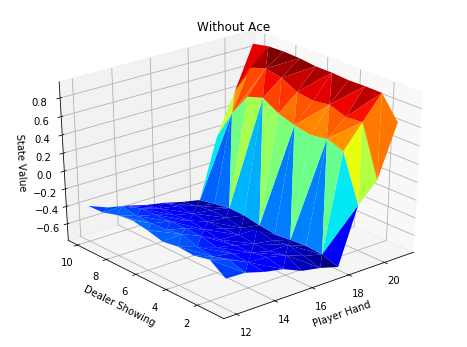

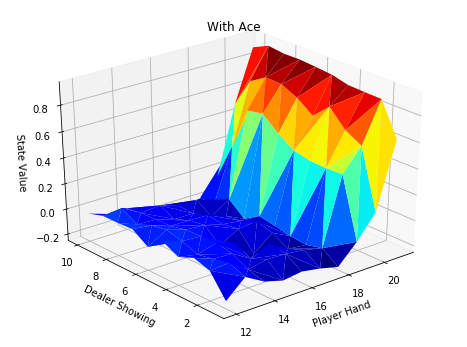

In [2]:
def MCPE(episodes, policy, env):
    # initial
    v = {key: 0 for key in itertools.product(np.arange(12,22),np.arange(1,11),np.arange(2))}
    v_count = {key: 0 for key in itertools.product(np.arange(12,22),np.arange(1,11),np.arange(2))}
    
    for episode in range(episodes):
        G = []
        states = []
        env.reset_game()
        old_state = env.state
        states.append(old_state)
        # implement the policy
        while env.active == True:
            if old_state[0] >= policy:
                new_state, reward = env.make_step(action="stick")
            else:
                new_state, reward = env.make_step(action="hit")
            states.append(new_state)
            G.append(reward)
            
            # incremental update values
            if env.active == False:
                for s_i, s in enumerate(states[:-1]):
                    returns = np.mean(G[s_i:])
                    v_count[s[0], s[1], s[2]] += 1
                    v[s[0], s[1], s[2]] = v[s[0], s[1], s[2]] +   \
                                          (returns - v[s[0], s[1], s[2]]) / v_count[s[0], s[1], s[2]]

            old_state = new_state
            
    return v

# train
v = MCPE(100000,19, env)

# plot to see if it's correct
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
%matplotlib inline
x,y,z,X,Y,Z = [],[],[],[],[],[]
for i in v.keys():
    if i[2] == 0:
        x.append(i[0])
        y.append(i[1])
        z.append(v[i])
    else:
        X.append(i[0])
        Y.append(i[1])
        Z.append(v[i])
        
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.azim = 230
ax.plot_trisurf(x,y,z, linewidth=.02, cmap=cm.jet)
ax.set_title("Without Ace")
ax.set_xlabel("Player Hand")
ax.set_ylabel("Dealer Showing")
ax.set_zlabel("State Value")
plt.show()

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.azim = 230
ax.plot_trisurf(X,Y,Z, linewidth=.02, cmap=cm.jet)
ax.set_title("With Ace")
ax.set_xlabel("Player Hand")
ax.set_ylabel("Dealer Showing")
ax.set_zlabel("State Value")
plt.show()